In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-wisconsin-data/data.csv


## UPVOTE If you like the work

# Reading the data and general info

In [2]:
cancer_df = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')

In [3]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [4]:
print("We can see that there is no missing data except the last column which we can remove as it has no significance")
cancer_df.drop('Unnamed: 32',axis = 1,inplace=True)

We can see that there is no missing data except the last column which we can remove as it has no significance


# EDA and preprocessing

In [5]:
# Desciptive summary of database
cancer_df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [6]:
# Finding the no. of benign and malignant
cancer_df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

There are two types of dignosis B for benign and M for malignant. We convert them into integer values M:1 
B:1
there is a slight imbalance in the dataset ( number of Benign(0) cases is more than number of Malignant(1) cases). The imbalance is not too much to worry about in this case.

In [7]:
# Grouping data based on diagnosis
cancer_df.groupby('diagnosis').mean()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,
B,2.654382e+07,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,...,13.379801,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442
M,3.681805e+07,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,...,21.134811,29.318208,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530


This tells us that the mean value for most of the features are greater for Malignant cases than the mean value for Benign cases.

In [8]:
cancer_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [9]:
cancer_df['diagnosis'].replace({'M':1,'B':0},inplace=True)
cancer_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
# Dropping the id column 
cancer_df.drop('id',axis=1,inplace=True)
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

# Visualisations

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

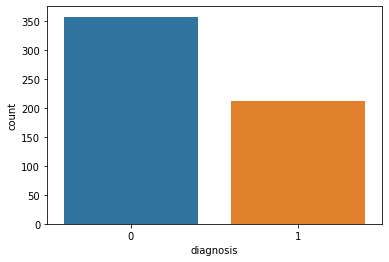

In [11]:
sns.countplot(x='diagnosis',data=cancer_df)

the number of data points with label “0” is higher than label “1”. This means that we have more Benign cases compared to Malignant cases in the dataset. 

### Distribution plot for all the columns

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


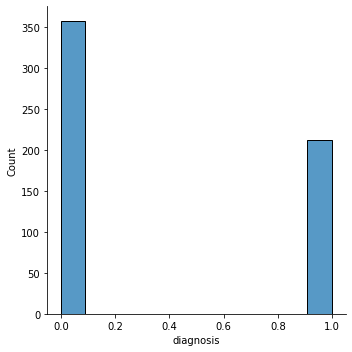

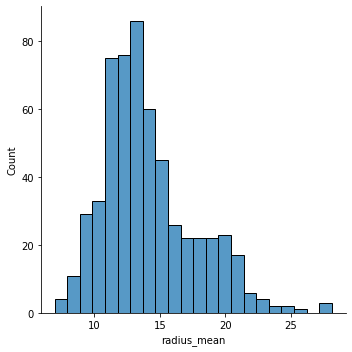

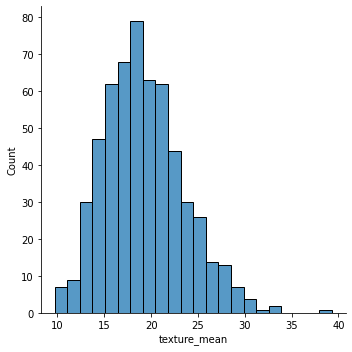

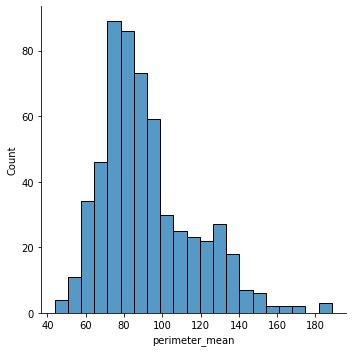

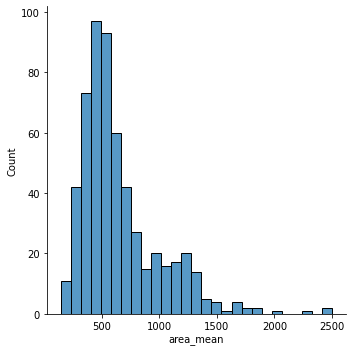

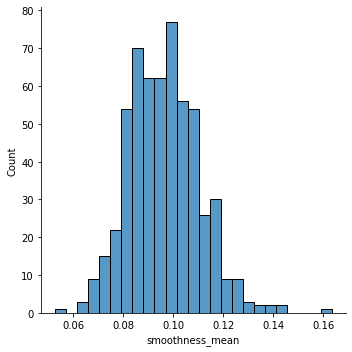

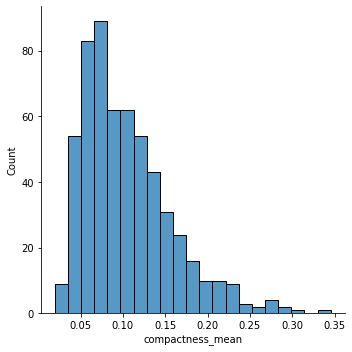

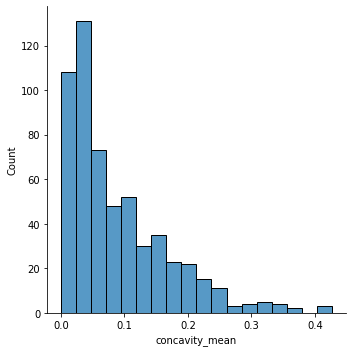

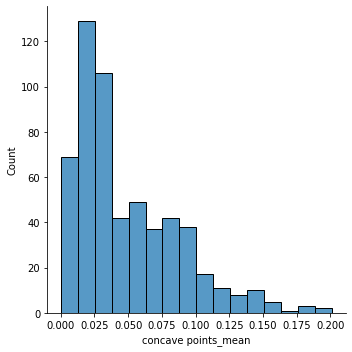

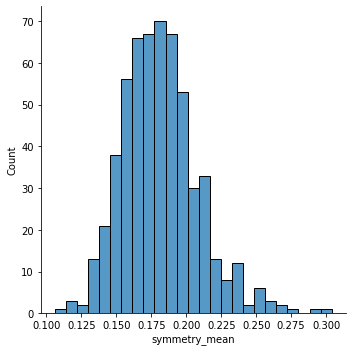

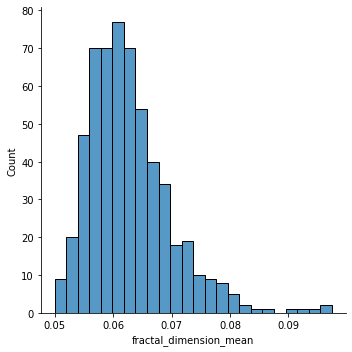

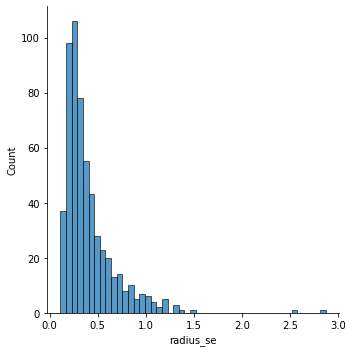

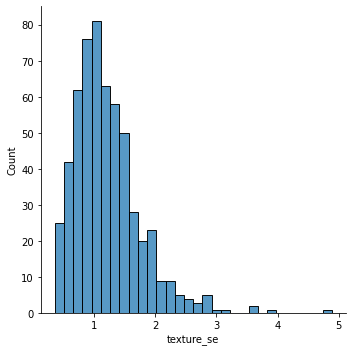

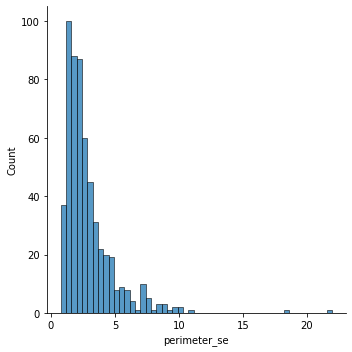

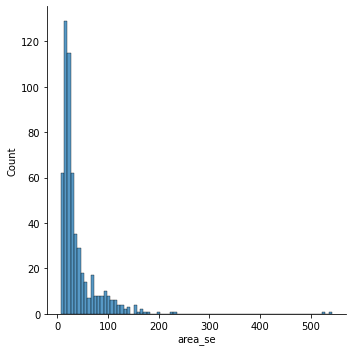

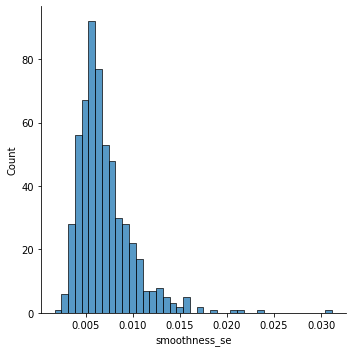

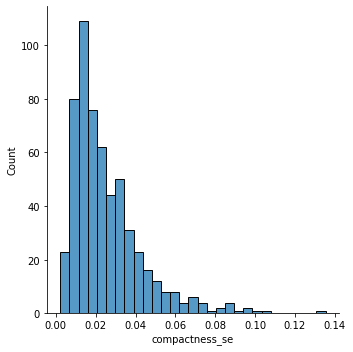

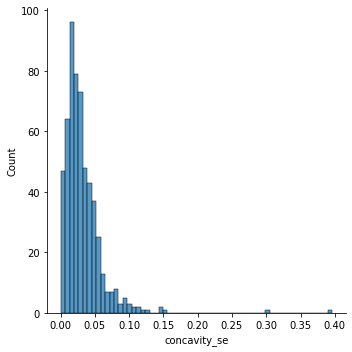

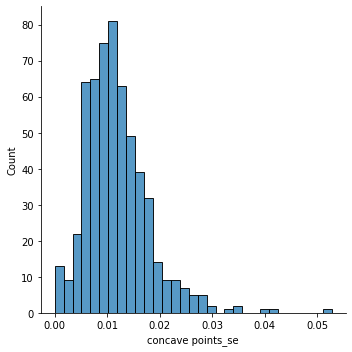

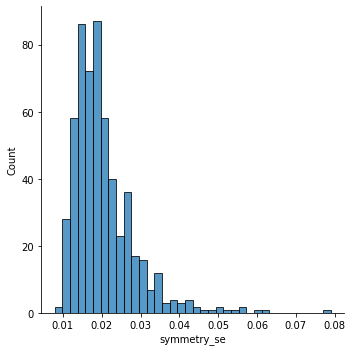

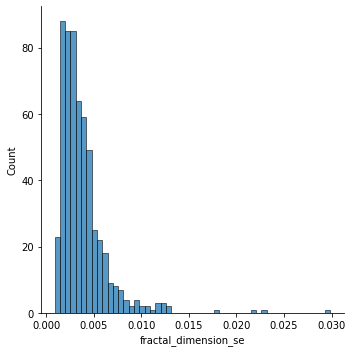

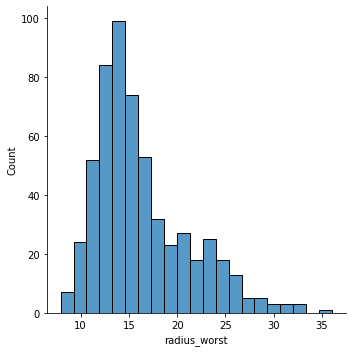

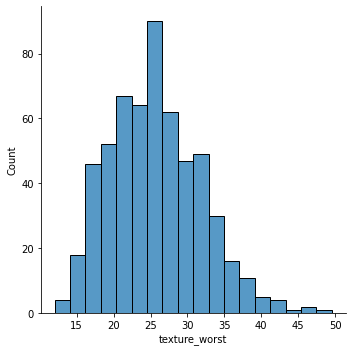

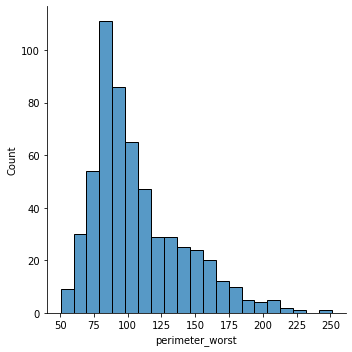

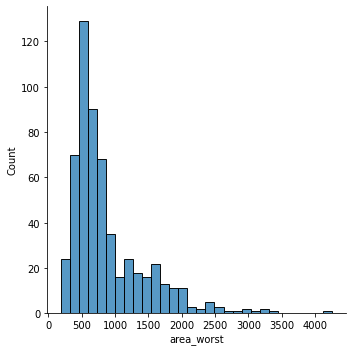

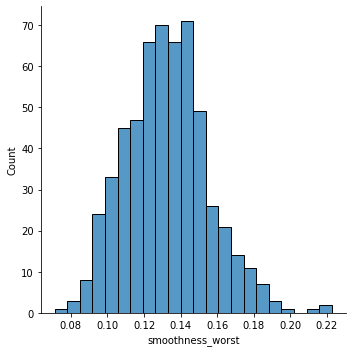

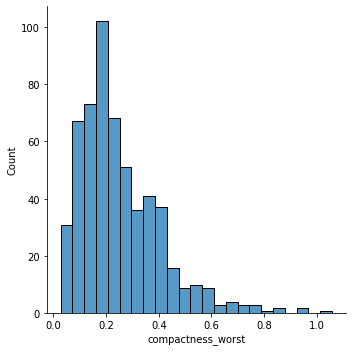

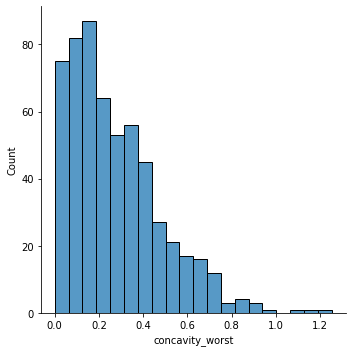

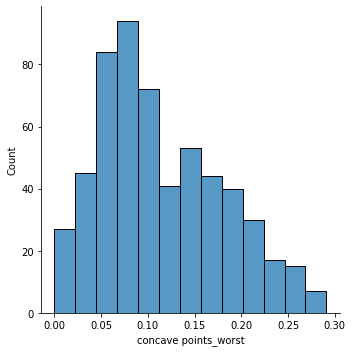

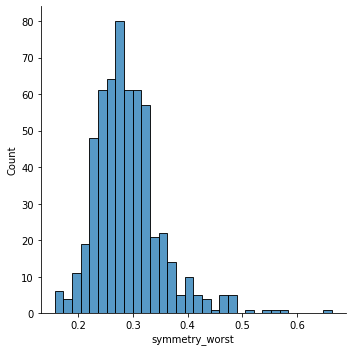

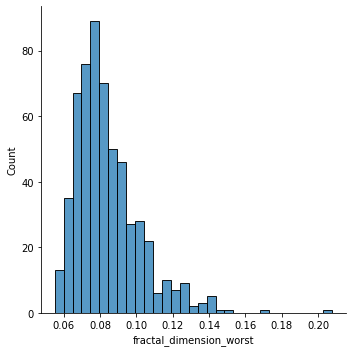

In [12]:
for column in cancer_df:
    sns.displot(x=column,data=cancer_df)

we are executing a for loop which will create distribution plot for all the columns in the dataset.most of the columns have right skewness in this dataset.

### Relationship between target variable and each column

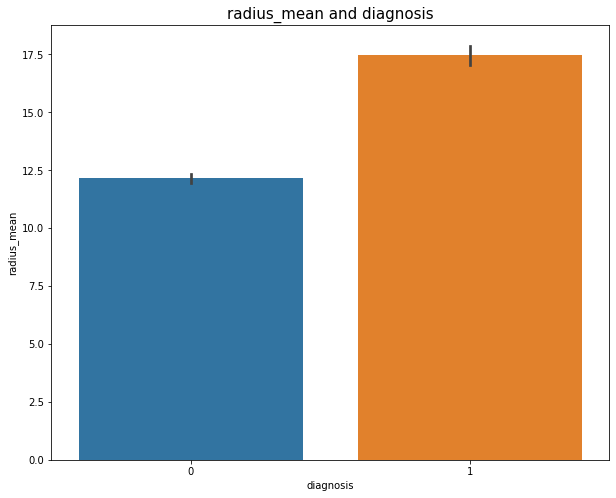

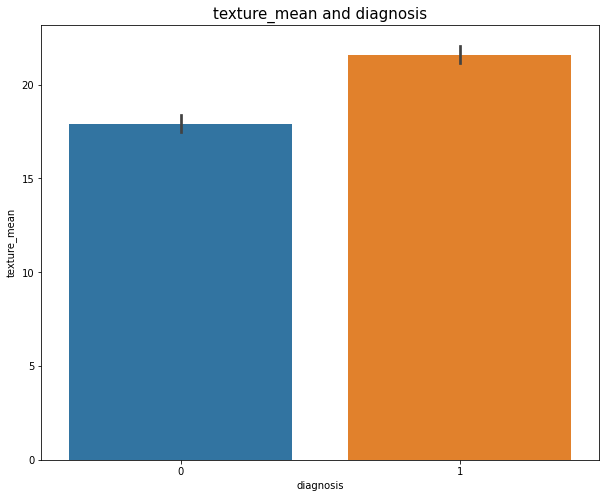

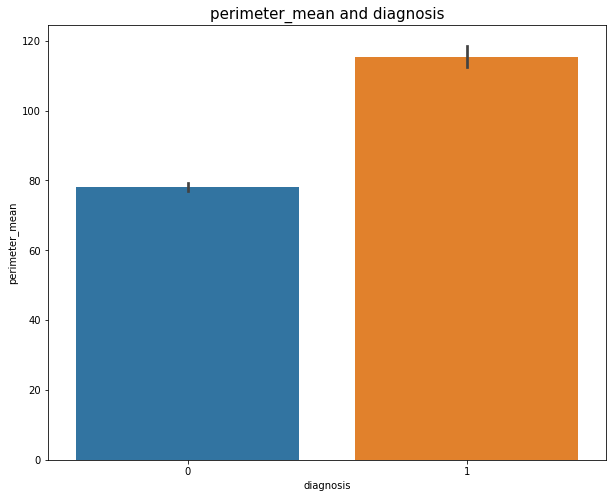

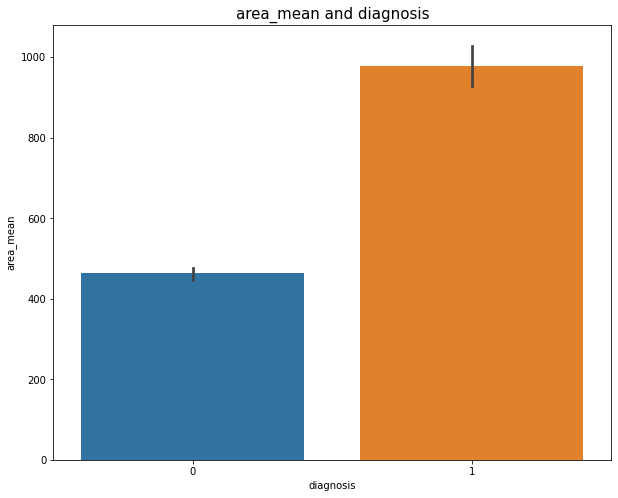

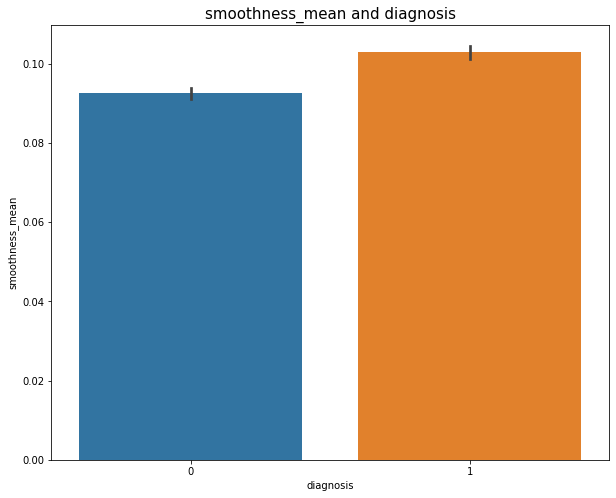

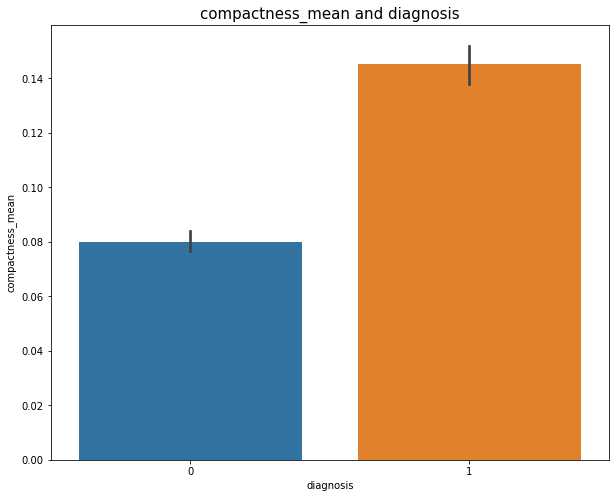

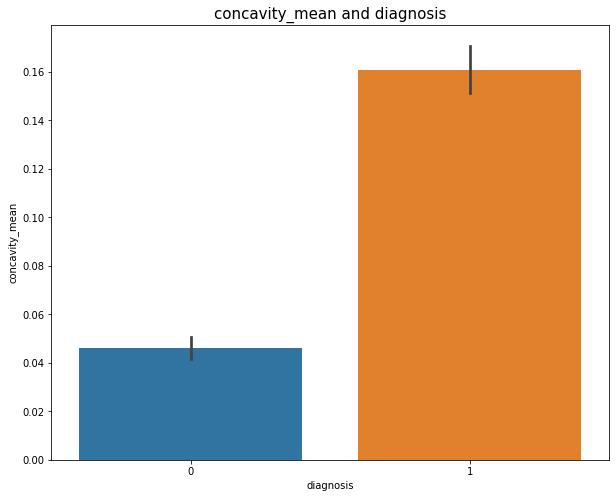

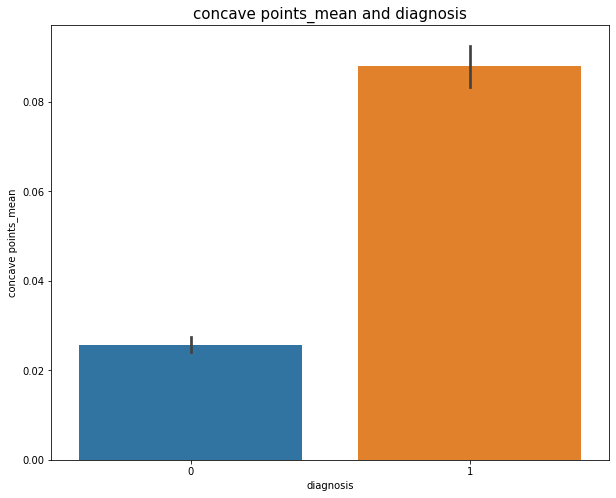

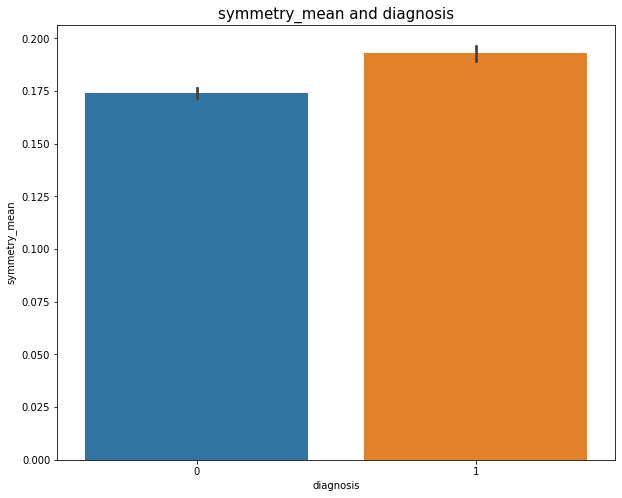

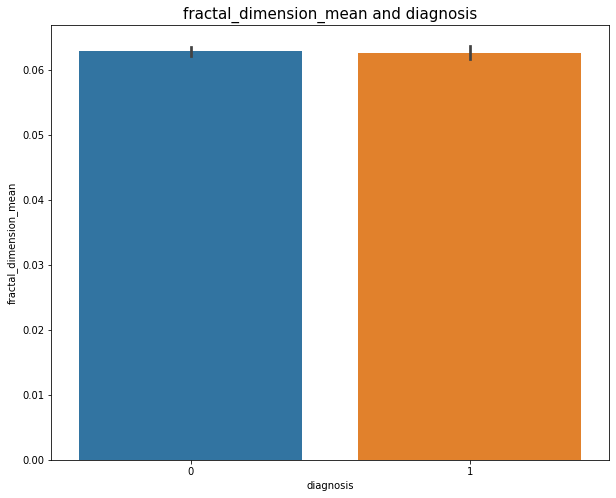

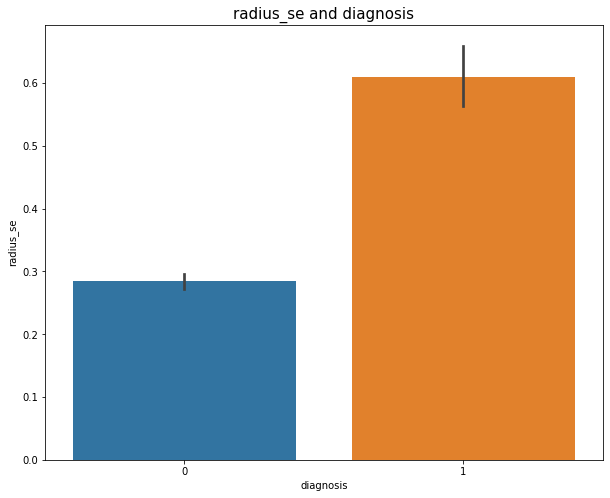

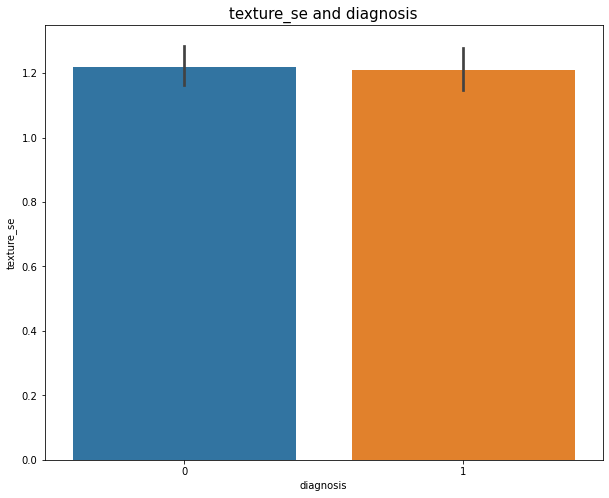

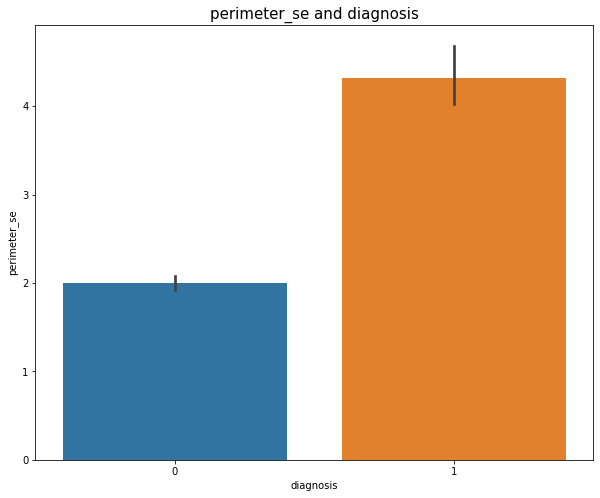

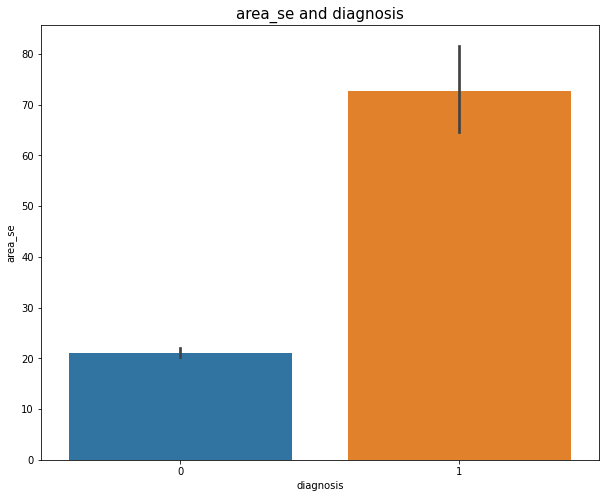

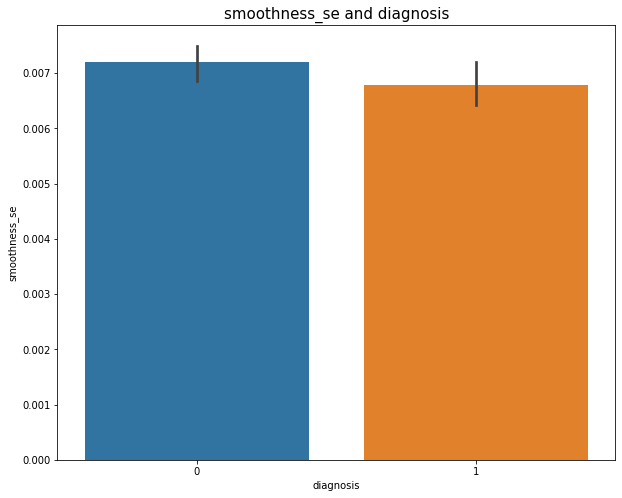

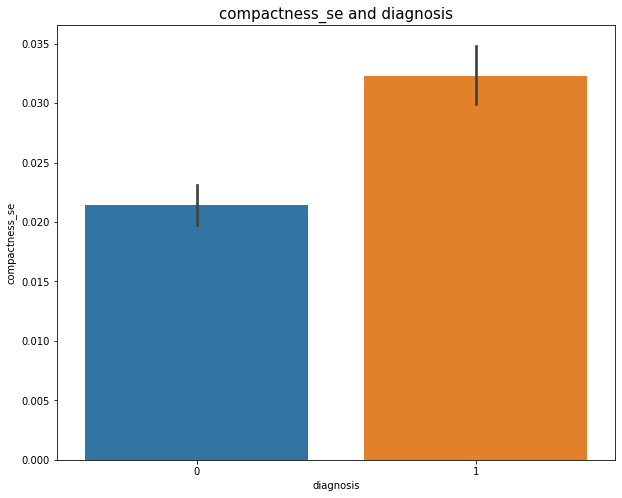

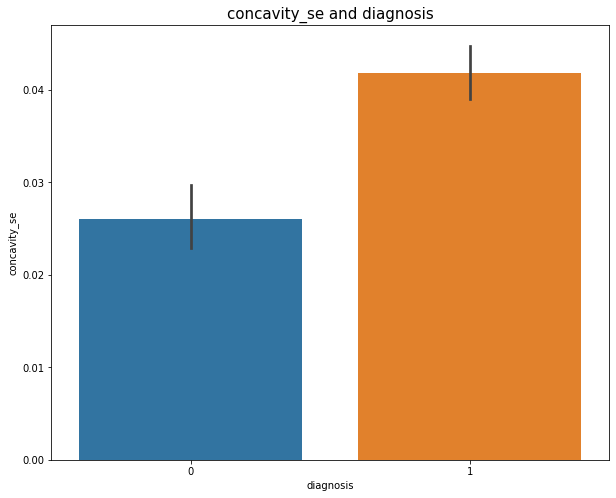

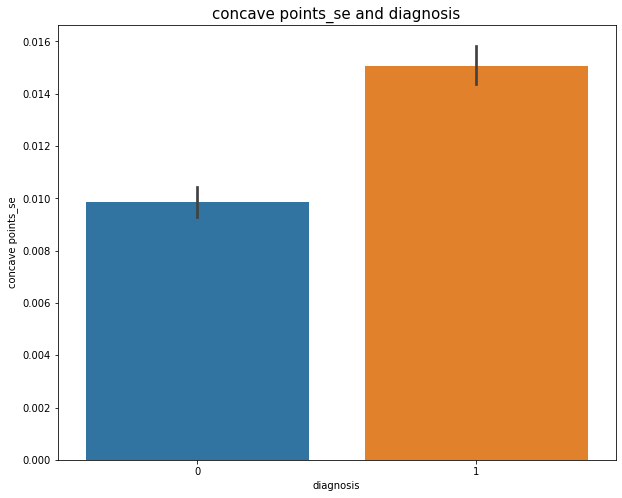

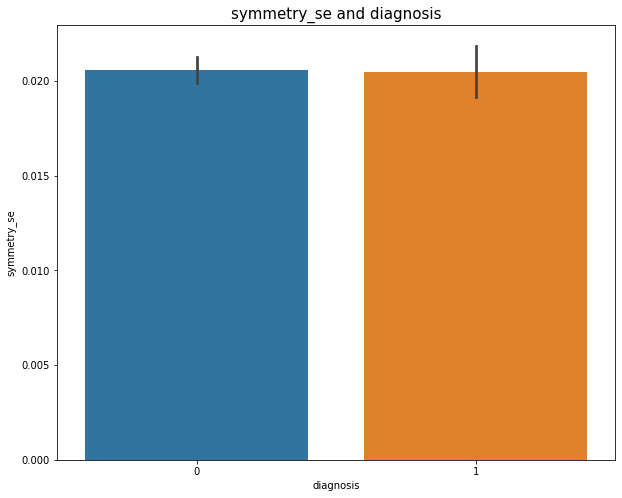

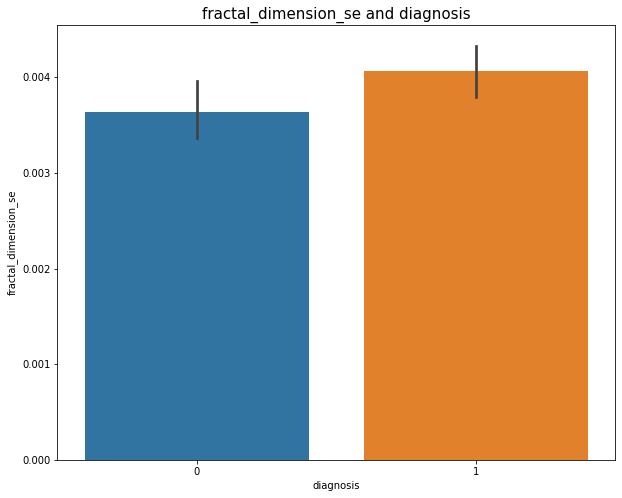

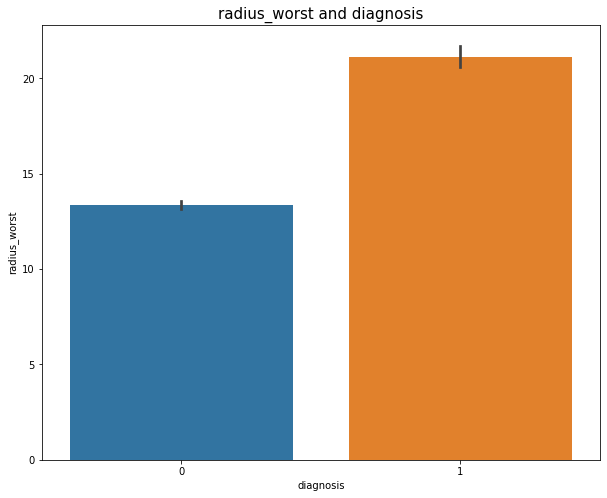

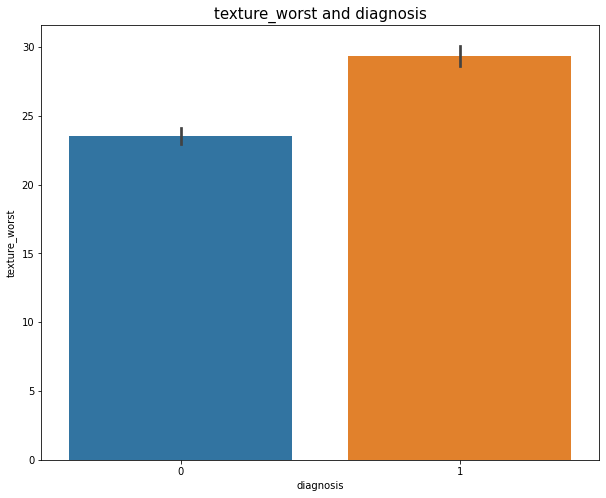

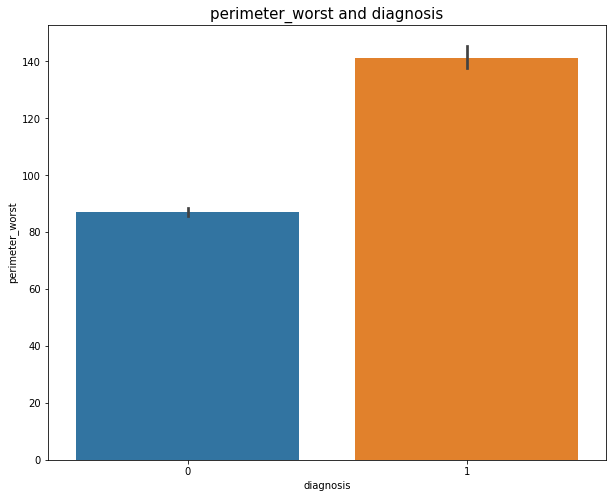

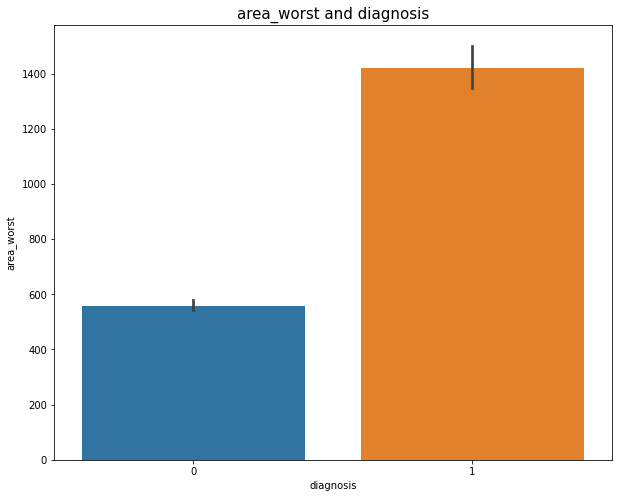

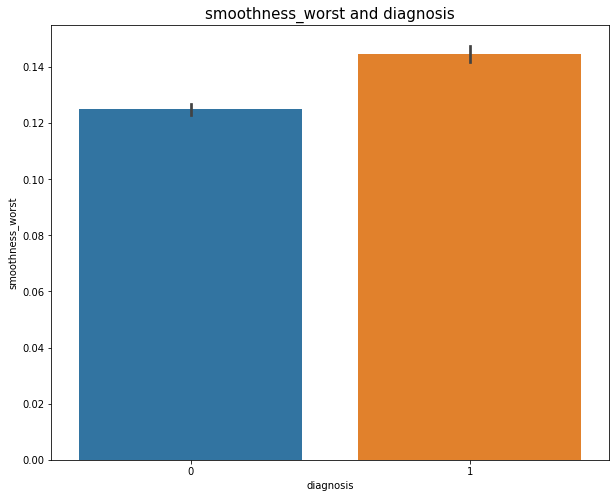

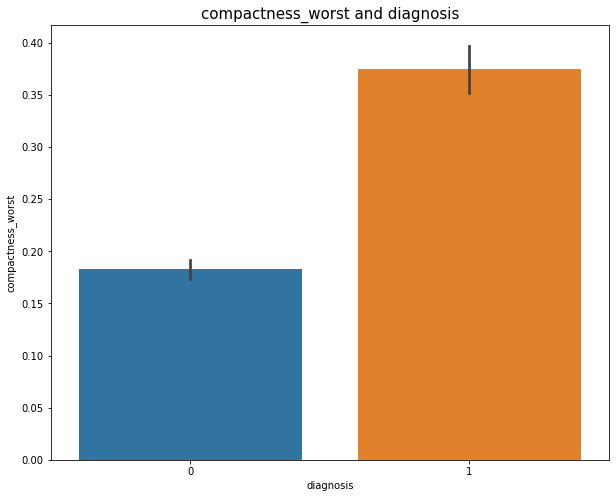

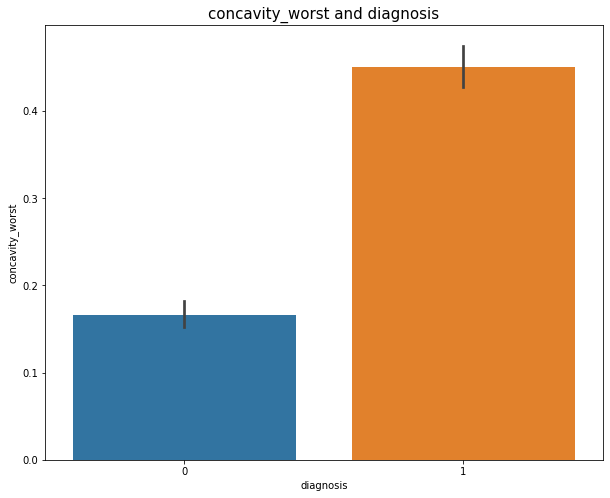

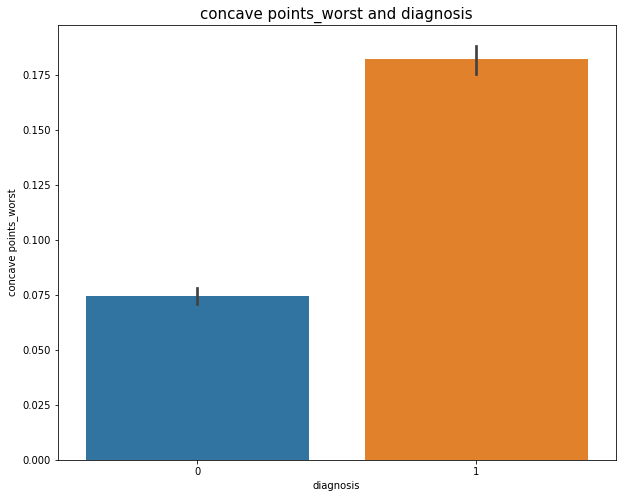

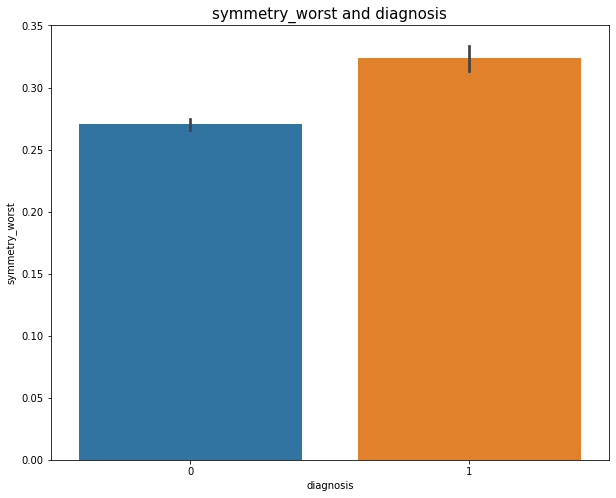

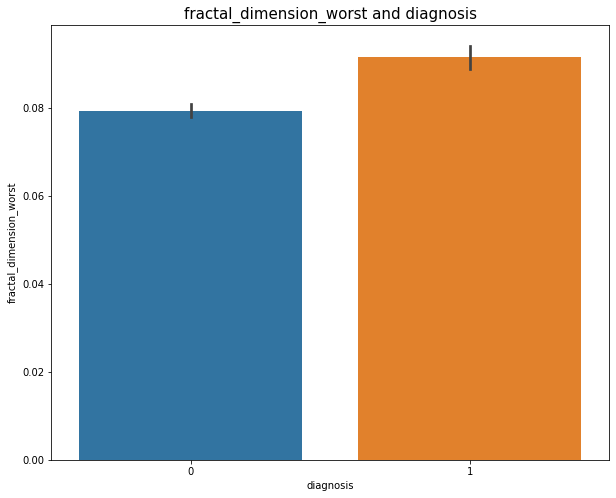

In [13]:
for col in cancer_df.drop("diagnosis", axis=1).columns:
    plt.figure(figsize=(10,8))
    sns.barplot(x=cancer_df["diagnosis"], y=cancer_df[col])
    plt.title(f"{col} and diagnosis", size=15)
    plt.show()

### Checking for Outliers

Outliers detection is one of the important tasks that we have to do. Most of the Machine Learning models like Regression models, K-Nearest Neighbors, etc. are sensitive to outliers. On the other hand, models like Random Forest are not affected by Outliers. So we should process these outliers before feeding the data to those models. This will also be carried out in the Feature Engineering part. We will be creating a Box and Whisker plot in order to check the outliers.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


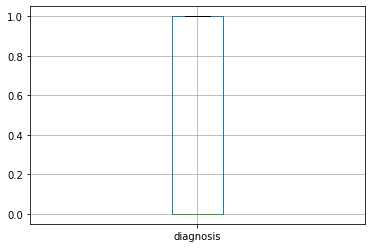

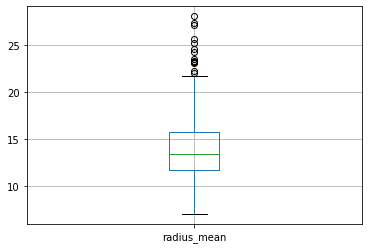

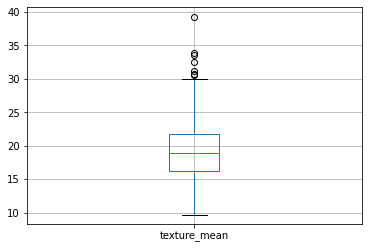

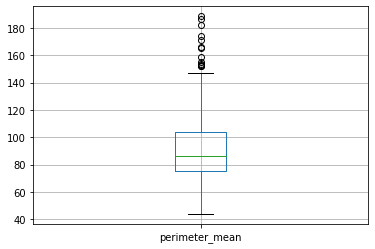

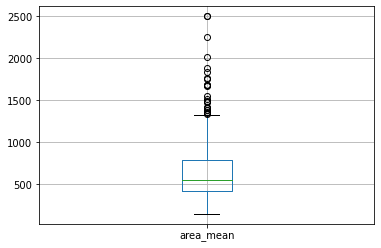

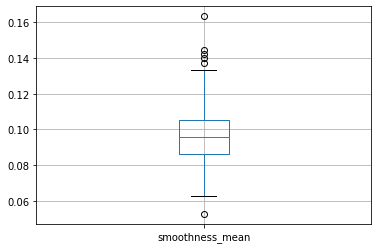

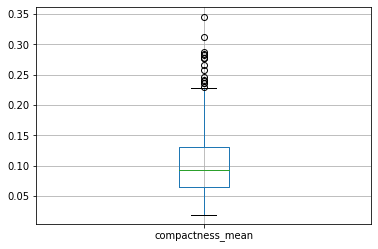

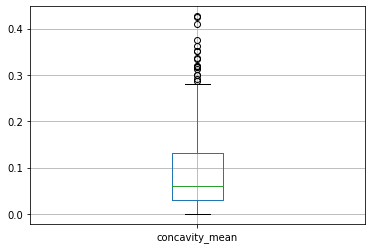

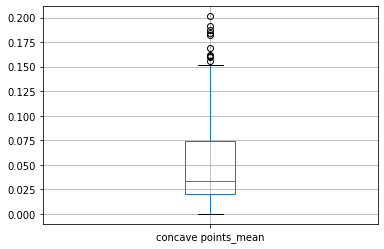

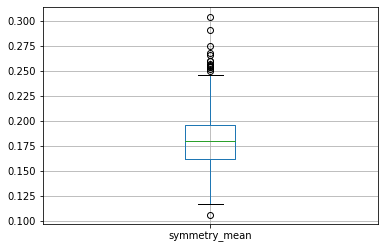

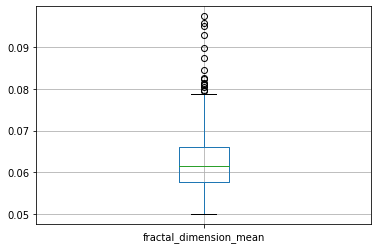

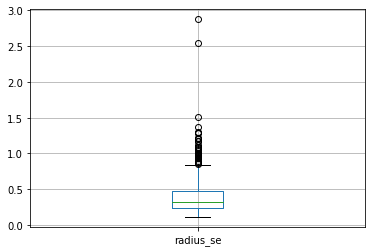

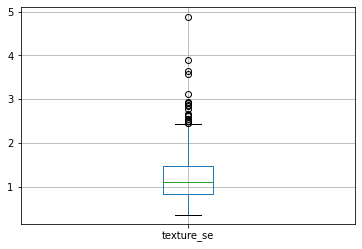

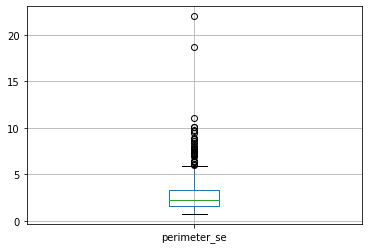

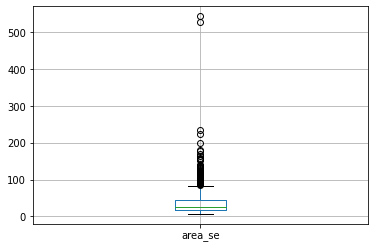

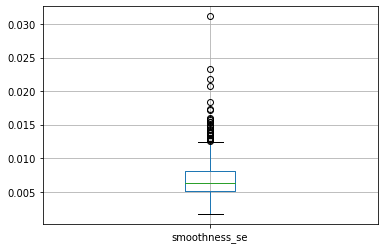

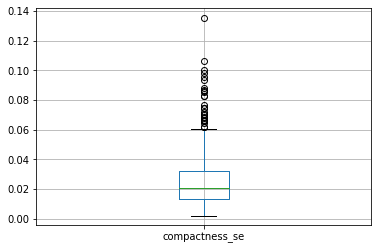

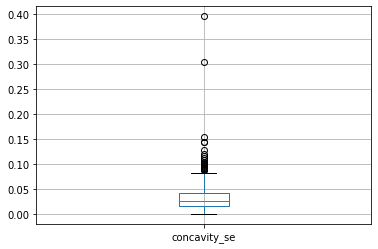

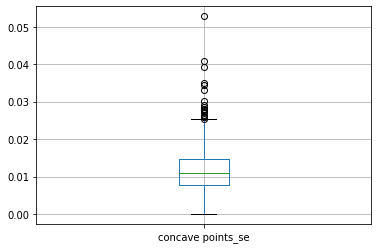

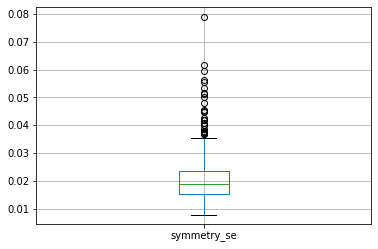

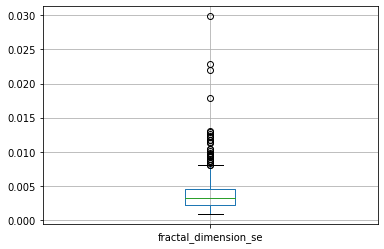

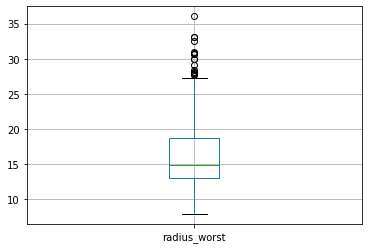

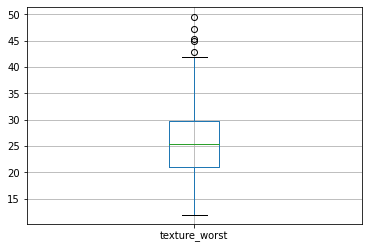

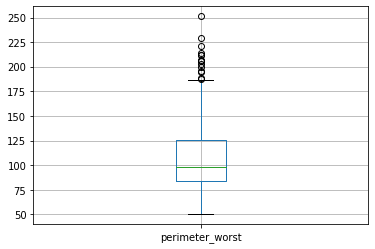

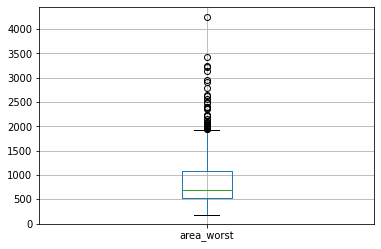

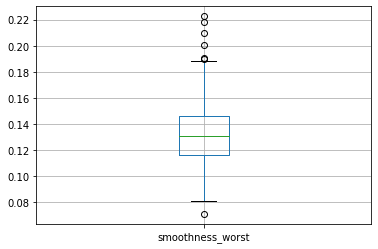

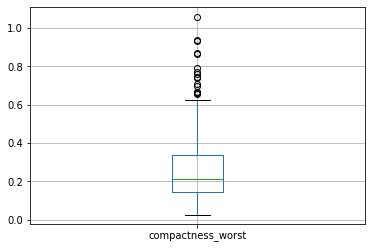

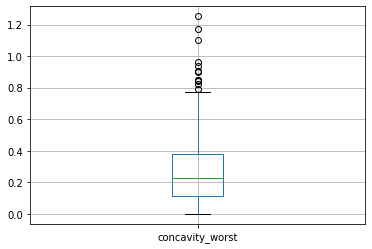

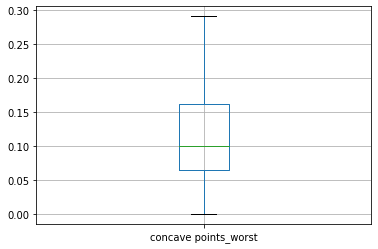

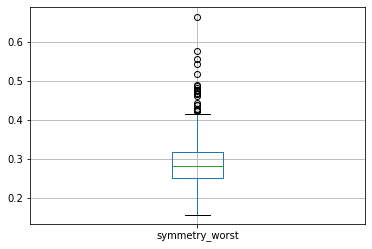

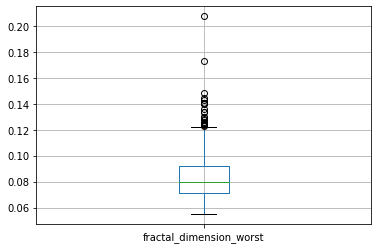

In [14]:
for column in cancer_df:
   plt.figure()
   cancer_df.boxplot([column])

The circles above the top whisker and below the bottom whisker represents the Outliers. Here we have outliers in the upper range alone.

### Correlation matrix

The main purpose of a correlation matrix is to understand the correlation (in other words, relationship) between the variables present in a dataset. It is very helpful in Feature Selection which is carried out to choose the important features and remove the irrelevant and unnecessary features.

<AxesSubplot:>

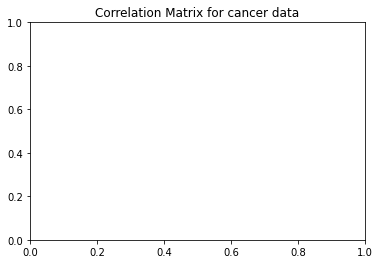

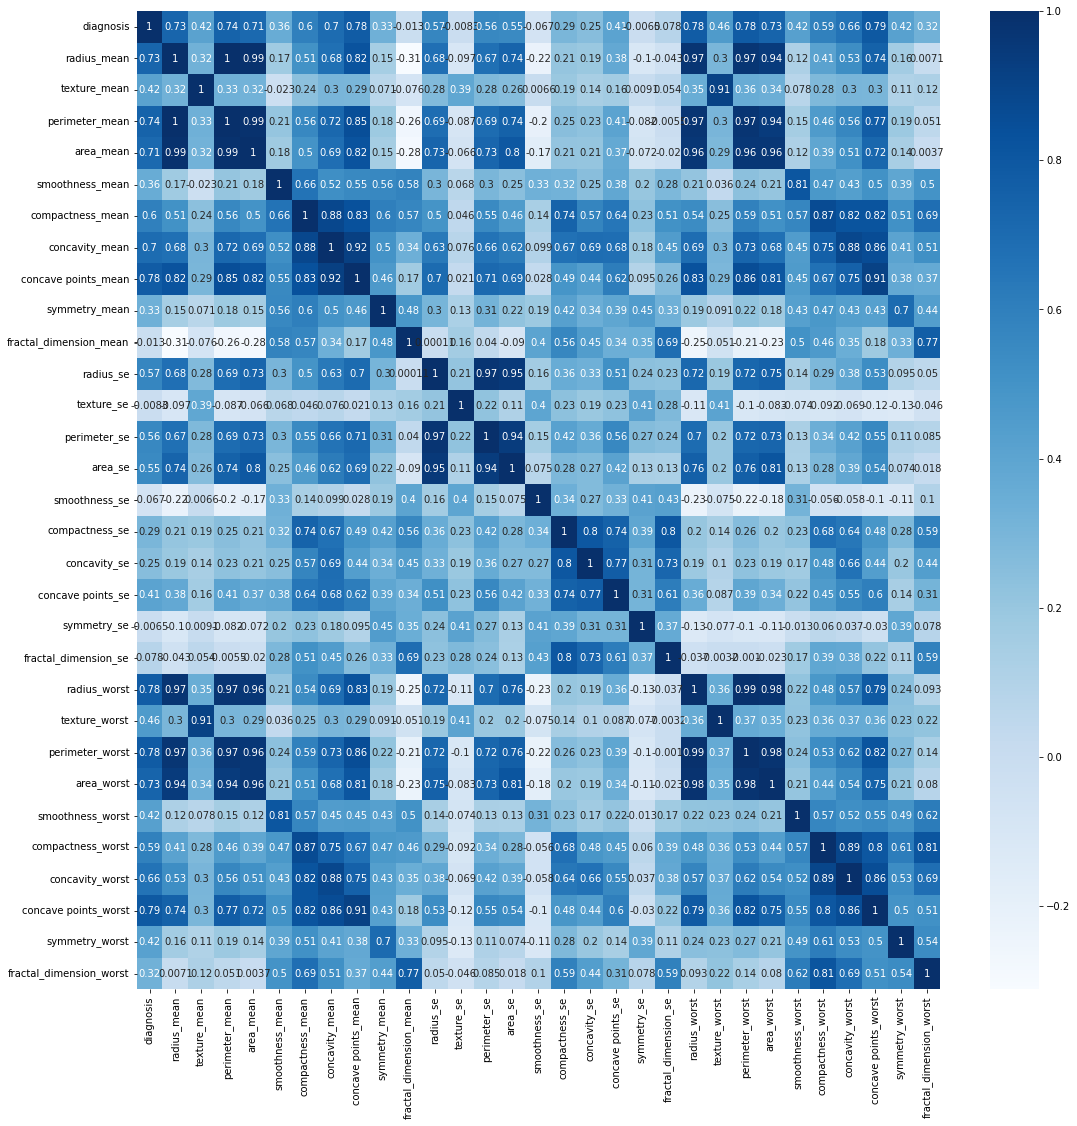

In [15]:

corr = cancer_df.corr()
plt.title('Correlation Matrix for cancer data')
plt.figure(figsize = (18,18))
sns.heatmap(corr, cmap='Blues',annot=True)

In [16]:
# Printing correlation for each column
cancer_df[cancer_df.columns[:]].corr()['diagnosis']

diagnosis                  1.000000
radius_mean                0.730029
texture_mean               0.415185
perimeter_mean             0.742636
area_mean                  0.708984
smoothness_mean            0.358560
compactness_mean           0.596534
concavity_mean             0.696360
concave points_mean        0.776614
symmetry_mean              0.330499
fractal_dimension_mean    -0.012838
radius_se                  0.567134
texture_se                -0.008303
perimeter_se               0.556141
area_se                    0.548236
smoothness_se             -0.067016
compactness_se             0.292999
concavity_se               0.253730
concave points_se          0.408042
symmetry_se               -0.006522
fractal_dimension_se       0.077972
radius_worst               0.776454
texture_worst              0.456903
perimeter_worst            0.782914
area_worst                 0.733825
smoothness_worst           0.421465
compactness_worst          0.590998
concavity_worst            0

In [17]:
# Features with more high correlated features
list = corr[abs(corr['diagnosis'])>=0.5].index
print("***********Positive  Correlation features**********")
print(list)


***********Positive  Correlation features**********
Index(['diagnosis', 'radius_mean', 'perimeter_mean', 'area_mean',
       'compactness_mean', 'concavity_mean', 'concave points_mean',
       'radius_se', 'perimeter_se', 'area_se', 'radius_worst',
       'perimeter_worst', 'area_worst', 'compactness_worst', 'concavity_worst',
       'concave points_worst'],
      dtype='object')


In [18]:
# Features with more least correlated features
list2 = corr[abs(corr['diagnosis'])<=0.5].index
print("*********** Negative  Correlation features**********")
print(list2)

*********** Negative  Correlation features**********
Index(['texture_mean', 'smoothness_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'texture_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'texture_worst', 'smoothness_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [19]:
# Based on above correlations , selecting the 20 most important columns
cancer_df = cancer_df[['diagnosis', 'radius_mean', 'area_mean',
       'compactness_mean', 'concavity_mean', 'concave points_mean',
       'perimeter_worst', 'area_worst', 'compactness_worst',
       'concavity_worst', 'concave points_worst','texture_mean', 
         'smoothness_mean', 'symmetry_mean','area_se','fractal_dimension_se',
         'texture_worst', 'smoothness_worst', 'symmetry_worst',
       'fractal_dimension_worst']]
cancer_df.head()

,diagnosis,radius_mean,area_mean,compactness_mean,concavity_mean,concave points_mean,perimeter_worst,area_worst,compactness_worst,concavity_worst,concave points_worst,texture_mean,smoothness_mean,symmetry_mean,area_se,fractal_dimension_se,texture_worst,smoothness_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,1001.0,0.27760,0.3001,0.14710,184.60,2019.0,0.6656,0.7119,0.2654,10.38,0.11840,0.2419,153.40,0.006193,17.33,0.1622,0.4601,0.11890
1,1,20.57,1326.0,0.07864,0.0869,0.07017,158.80,1956.0,0.1866,0.2416,0.1860,17.77,0.08474,0.1812,74.08,0.003532,23.41,0.1238,0.2750,0.08902
2,1,19.69,1203.0,0.15990,0.1974,0.12790,152.50,1709.0,0.4245,0.4504,0.2430,21.25,0.10960,0.2069,94.03,0.004571,25.53,0.1444,0.3613,0.08758
3,1,11.42,386.1,0.28390,0.2414,0.10520,98.87,567.7,0.8663,0.6869,0.2575,20.38,0.14250,0.2597,27.23,0.009208,26.50,0.2098,0.6638,0.17300
4,1,20.29,1297.0,0.13280,0.1980,0.10430,152.20,1575.0,0.2050,0.4000,0.1625,14.34,0.10030,0.1809,94.44,0.005115,16.67,0.1374,0.2364,0.07678


In [20]:
cancer_df.shape

(569, 20)

In [21]:
final_df = cancer_df.copy()

In [22]:
from sklearn.model_selection import train_test_split
X = final_df.drop(['diagnosis'],axis=1)
y = final_df['diagnosis']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [23]:
x_test

,radius_mean,area_mean,compactness_mean,concavity_mean,concave points_mean,perimeter_worst,area_worst,compactness_worst,concavity_worst,concave points_worst,texture_mean,smoothness_mean,symmetry_mean,area_se,fractal_dimension_se,texture_worst,smoothness_worst,symmetry_worst,fractal_dimension_worst
204,12.47,481.9,0.10580,0.08005,0.03821,96.05,677.9,0.2378,0.2671,0.10150,18.60,0.09965,0.1925,30.29,0.003586,24.64,0.1426,0.3014,0.08750
70,18.94,1130.0,0.10290,0.10800,0.07951,165.90,1866.0,0.2336,0.2687,0.17890,21.31,0.09009,0.1582,96.05,0.001698,26.58,0.1193,0.2551,0.06589
131,15.46,748.9,0.12230,0.14660,0.08087,124.90,1156.0,0.2394,0.3791,0.15140,19.48,0.10920,0.1931,48.31,0.002461,26.00,0.1546,0.2837,0.08019
431,12.40,467.8,0.13160,0.07741,0.02799,89.61,515.8,0.2629,0.2403,0.07370,17.68,0.10540,0.1811,15.43,0.006005,22.91,0.1450,0.2556,0.09359
540,11.54,402.9,0.11200,0.06737,0.02594,78.78,457.8,0.2118,0.1797,0.06918,14.44,0.09984,0.1818,20.86,0.005512,19.68,0.1345,0.2329,0.08134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,14.64,666.0,0.06698,0.05192,0.02791,106.00,831.0,0.2070,0.2437,0.07828,16.85,0.08641,0.1409,19.98,0.001219,25.44,0.1142,0.2455,0.06596
75,16.07,817.7,0.08424,0.09769,0.06638,128.80,1223.0,0.2045,0.2829,0.15200,19.65,0.09168,0.1798,79.25,0.001948,24.56,0.1500,0.2650,0.06387
249,11.52,406.3,0.07808,0.04328,0.02929,80.88,491.8,0.1582,0.1804,0.09608,14.93,0.10130,0.1883,18.62,0.002784,21.19,0.1389,0.2664,0.07809
238,14.22,623.9,0.10390,0.11030,0.04408,102.50,764.0,0.2426,0.3064,0.08219,27.85,0.08223,0.1342,29.96,0.003589,40.54,0.1081,0.1890,0.07796


## Scaling the features

In [24]:
cols = x_train.columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train[cols] = scaler.fit_transform(x_train[cols])
x_test[cols] = scaler.fit_transform(x_test[cols])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


# Logistic Regression

In [25]:
model = LogisticRegression(solver='liblinear')
model.fit(x_train,y_train)
print(f"\nThe accuracy score with Logistic Regression is {model.score(x_test,y_test)}")


The accuracy score with Logistic Regression is 0.9824561403508771


In [26]:
# Checking cross val score for this model
cross_val_score(model, X,y,cv=3)

array([0.93684211, 0.96842105, 0.94179894])

<AxesSubplot:>

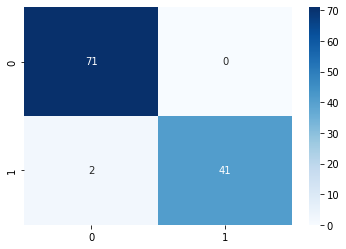

In [27]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
prediction = model.predict(x_test)
cf = confusion_matrix(y_test, prediction)
sns.heatmap(cf,cmap = 'Blues',annot = True)

In [28]:
# Classification report for Logistic Regression
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



# Decision Tree

In [29]:
model2 = DecisionTreeClassifier()
model2.fit(x_train, y_train)
print(f"Acuuracy score with decision tree is {model2.score(x_test,y_test)}")

Acuuracy score with decision tree is 0.9122807017543859


In [30]:
# Checking cross val score for this model
cross_val_score(model2, X,y,cv=3)

array([0.88947368, 0.95263158, 0.85185185])

<AxesSubplot:>

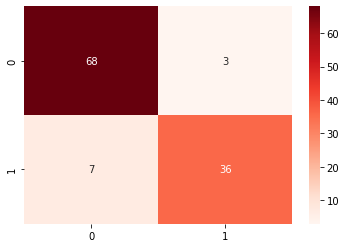

In [31]:
from sklearn.metrics import confusion_matrix
prediction = model2.predict(x_test)
cf = confusion_matrix(y_test, prediction)
sns.heatmap(cf,cmap = 'Reds',annot = True)

In [32]:
# Classification report for Logistic Regression
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93        71
           1       0.92      0.84      0.88        43

    accuracy                           0.91       114
   macro avg       0.91      0.90      0.90       114
weighted avg       0.91      0.91      0.91       114



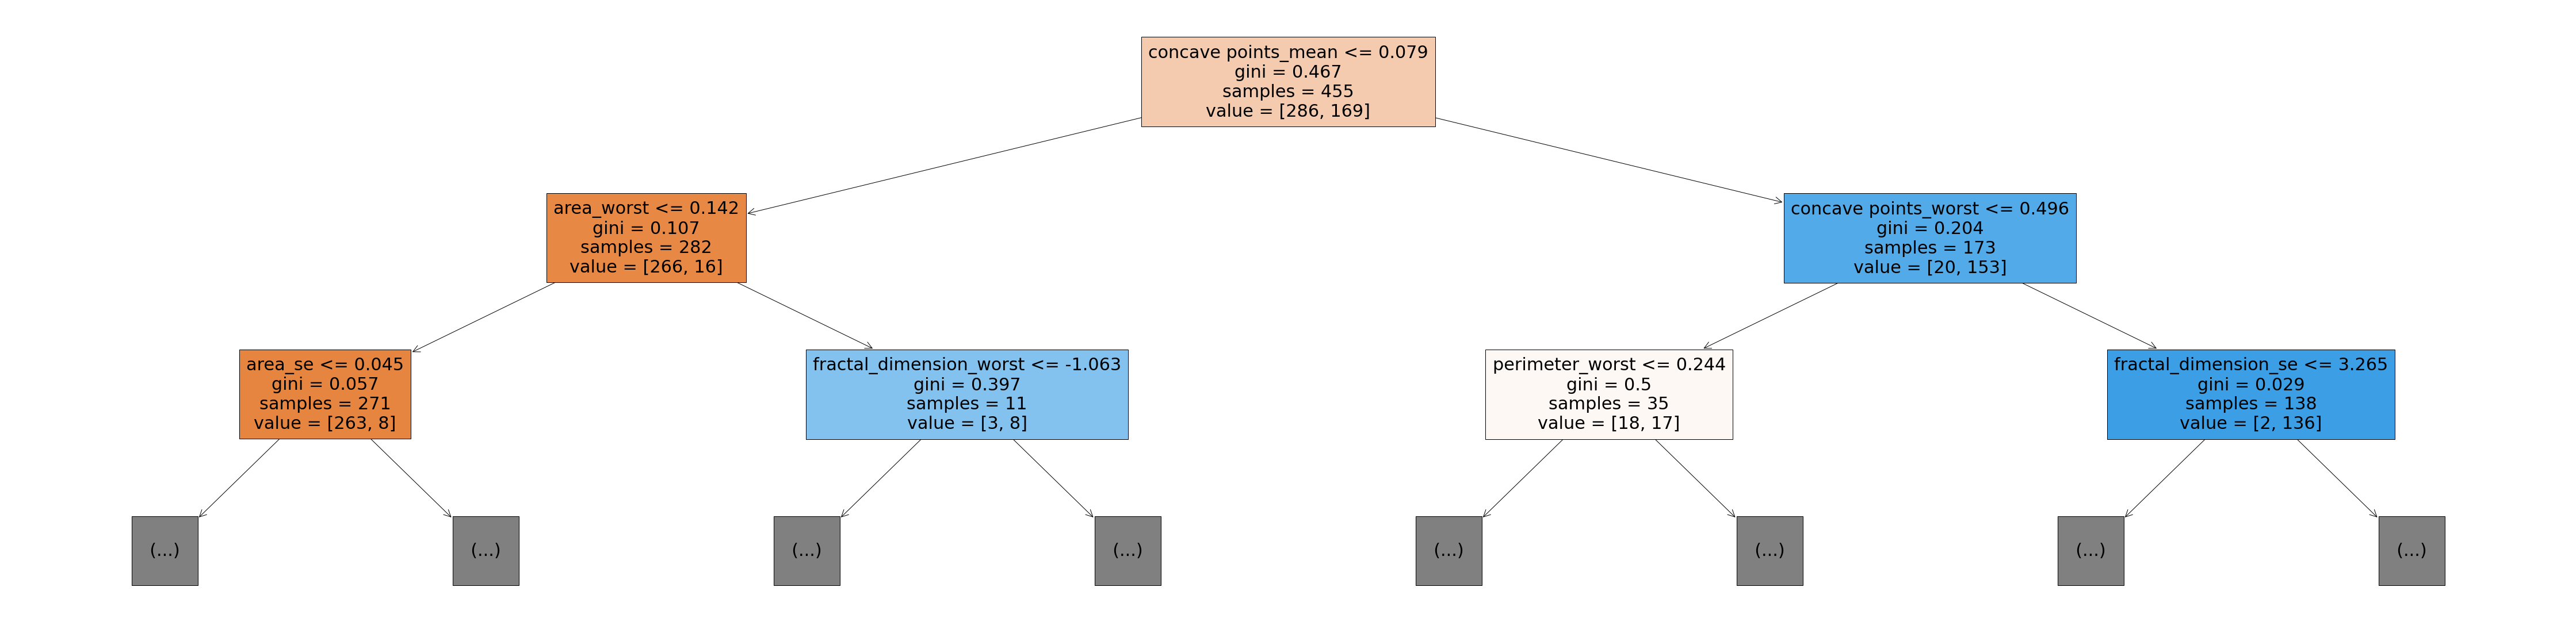

In [33]:
from sklearn.tree import plot_tree
plt.figure(figsize=(80,20))
plot_tree(model2, feature_names=x_train.columns, max_depth=2, filled=True);

In [34]:
model2.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.69141955,
       0.05149396, 0.04844782, 0.00627578, 0.        , 0.06565079,
       0.        , 0.        , 0.0099505 , 0.01986432, 0.02891783,
       0.04003831, 0.01740223, 0.        , 0.0205389 ])

In [35]:
importance_df = pd.DataFrame({'features':x_train.columns,'importance':model2.feature_importances_}).sort_values('importance',ascending=False)

In [36]:
importance_df.head()

,features,importance
4,concave points_mean,0.691420
9,concave points_worst,0.065651
5,perimeter_worst,0.051494
6,area_worst,0.048448
15,texture_worst,0.040038


<AxesSubplot:xlabel='importance', ylabel='features'>

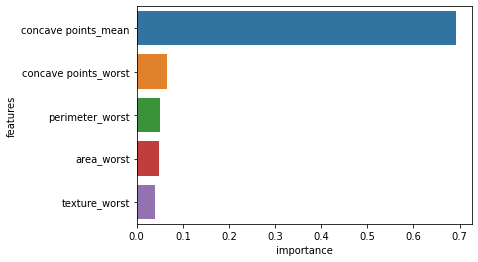

In [37]:
sns.barplot(x='importance',y='features',data=importance_df.head())

# Random Forest 

In [38]:
model3 = RandomForestClassifier()
model3.fit(x_train, y_train)
print(f"Accuracy Score with Random Forest is {model3.score(x_test,y_test)}")

Accuracy Score with Random Forest is 0.9649122807017544


In [39]:
# Checking cross val score for this model
cross_val_score(model3,X,y,cv=5)

array([0.92105263, 0.94736842, 0.99122807, 0.98245614, 0.96460177])

<AxesSubplot:>

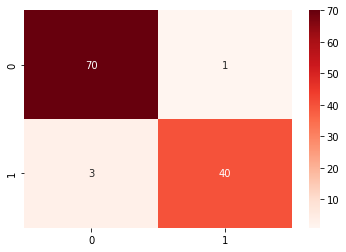

In [40]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
prediction = model3.predict(x_test)
cf = confusion_matrix(y_test, prediction)
sns.heatmap(cf,cmap = 'Reds',annot = True)

In [41]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [42]:
len(model3.estimators_)

100

In [43]:
model3.feature_importances_

array([0.03349126, 0.06087872, 0.00727631, 0.05953894, 0.12041571,
       0.13954976, 0.1731848 , 0.02133811, 0.04522448, 0.18851928,
       0.02185887, 0.00677381, 0.00431292, 0.04253369, 0.00911335,
       0.02434888, 0.01437839, 0.01897223, 0.0082905 ])

In [44]:
importance_df = pd.DataFrame({
    'feature': x_train.columns,
    'importance': model3.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head()

,feature,importance
9,concave points_worst,0.188519
6,area_worst,0.173185
5,perimeter_worst,0.139550
4,concave points_mean,0.120416
1,area_mean,0.060879


<AxesSubplot:xlabel='importance', ylabel='feature'>

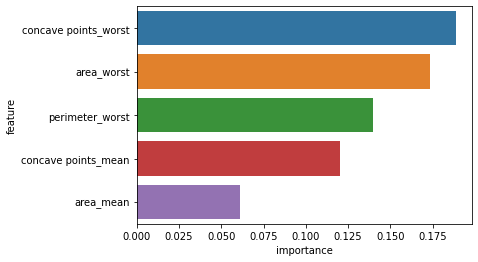

In [45]:
sns.barplot(x='importance',y='feature',data=importance_df.head())

# KNN

In [46]:
from sklearn.neighbors import KNeighborsClassifier
model4 = KNeighborsClassifier(n_neighbors = 3)
model4.fit(x_train, y_train)
print(f"Accuracy Score with KNN is {model4.score(x_test,y_test)}")

Accuracy Score with KNN is 0.956140350877193


In [47]:
# Checking cross_val_score for this model
cross_val_score(model4, X,y, cv=3)

array([0.89473684, 0.95263158, 0.91534392])

<AxesSubplot:>

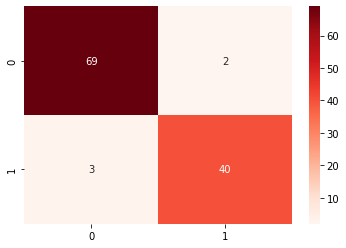

In [48]:
prediction = model4.predict(x_test)
cf = confusion_matrix(y_test, prediction)
sns.heatmap(cf,cmap = 'Reds',annot = True)

In [49]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



## Upvote If you like the work